In [1]:
# This Python 3 environment is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Input data files are available in the read-only "../input/" directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# Initial EDA

In [2]:
train_data = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")

train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
#test_data.head()

In [4]:
# find missing values and print data dimensions
print("Training:\n", train_data.shape, "\n")
print(train_data.isnull().sum(),"\n\n")
print("Test:\n", test_data.shape, "\n")
print(test_data.isnull().sum())

Training:
 (8693, 14) 

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64 


Test:
 (4277, 13) 

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


<AxesSubplot:>

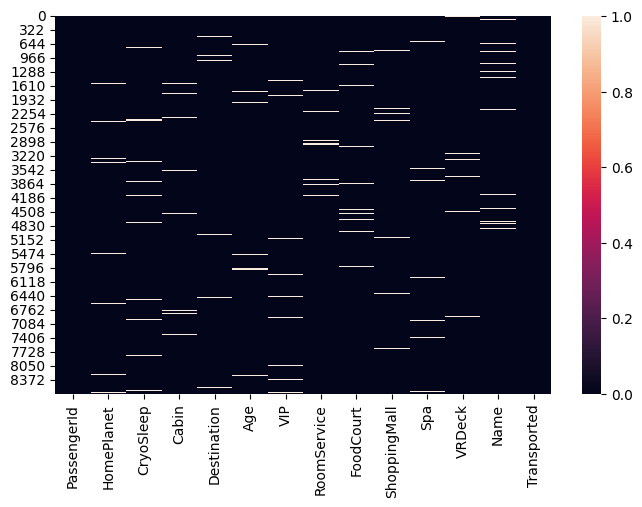

In [5]:
# visualize missing values
plt.figure(dpi=100, figsize=(8, 5))
sns.heatmap(train_data.isnull())

In [6]:
train_data.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [7]:
train_data.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

In [8]:
train_data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [9]:
for c in ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']:
    print(train_data[c].value_counts(), "\n")

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64 

False    5439
True     3037
Name: CryoSleep, dtype: int64 

TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64 

False    8291
True      199
Name: VIP, dtype: int64 



# New Features

In [10]:
# separate information in PassengerID and Cabin
train_data[['GroupId', 'MemberId']] = train_data['PassengerId'].str.split("_", expand=True)
train_data[['CabinDeck', 'CabinNum', 'CabinSide']] = train_data['Cabin'].str.split("/", expand=True)
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,GroupId,MemberId,CabinDeck,CabinNum,CabinSide
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,01,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,01,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,01,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,02,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,01,F,1,S


In [11]:
for c in ['CabinDeck', 'CabinNum', 'CabinSide']:
    print(train_data[c].value_counts(), "\n")

F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: CabinDeck, dtype: int64 

82      28
86      22
19      22
56      21
176     21
        ..
1644     1
1515     1
1639     1
1277     1
1894     1
Name: CabinNum, Length: 1817, dtype: int64 

S    4288
P    4206
Name: CabinSide, dtype: int64 



In [12]:
# create a total spending feature
train_data['TotalSpend'] = train_data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

In [13]:
# create a feature for group size
train_data['GroupSize'] = train_data.groupby('GroupId')['GroupId'].transform('count')
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,Transported,GroupId,MemberId,CabinDeck,CabinNum,CabinSide,TotalSpend,GroupSize
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,0.0,Maham Ofracculy,False,0001,01,B,0,P,0.0,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,44.0,Juanna Vines,True,0002,01,F,0,S,736.0,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,49.0,Altark Susent,False,0003,01,A,0,S,10383.0,2
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,193.0,Solam Susent,False,0003,02,A,0,S,5176.0,2
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,2.0,Willy Santantines,True,0004,01,F,1,S,1091.0,1


In [14]:
#check that people in CryoSleep are not spending money
train_data.groupby('CryoSleep')['TotalSpend'].describe()

,count,mean,std,min,25%,50%,75%,max
CryoSleep,,,,,,,,
False,5439.0,2248.299687,3245.061489,0.0,746.0,1019.0,2416.0,35987.0
True,3037.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


# EDA with new features

In [15]:
# find mutual information scores

from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import SimpleImputer

mi_df = train_data.copy()
mi_df = mi_df.drop(['PassengerId', 'Name'], axis=1)  # drop the columns with unique identifiers

# impute missing values
categ_imputer = SimpleImputer(strategy = 'most_frequent')
num_imputer = SimpleImputer(strategy = 'constant')

categ_cols = [cname for cname in mi_df.columns if mi_df[cname].dtype == "object"]
num_cols = [cname for cname in mi_df.columns if mi_df[cname].dtype in ['int64', 'float64']]

mi_df[categ_cols] = pd.DataFrame(categ_imputer.fit_transform(mi_df[categ_cols]))
mi_df[num_cols] = pd.DataFrame(num_imputer.fit_transform(mi_df[num_cols]))

# Label encoding for categoricals
for colname in mi_df.select_dtypes(["object", "bool"]):
    mi_df[colname], _ = mi_df[colname].factorize()
    
X = mi_df.copy()
y = X.pop("Transported")

# select discrete/categorical columns
discrete_feat = discrete_features = X.dtypes == int

mi_scores = mutual_info_classif(X, y, discrete_features=discrete_feat)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)
mi_scores

Cabin           0.542320
GroupId         0.512914
CabinNum        0.143284
TotalSpend      0.132592
CryoSleep       0.112254
Spa             0.078739
RoomService     0.072922
VRDeck          0.060460
ShoppingMall    0.050715
FoodCourt       0.044122
CabinDeck       0.022989
HomePlanet      0.018581
Age             0.010471
GroupSize       0.007919
Destination     0.006113
CabinSide       0.005149
MemberId        0.004350
VIP             0.000700
Name: MI Scores, dtype: float64

Text(0.5, 1.0, 'Mutual Information Scores')

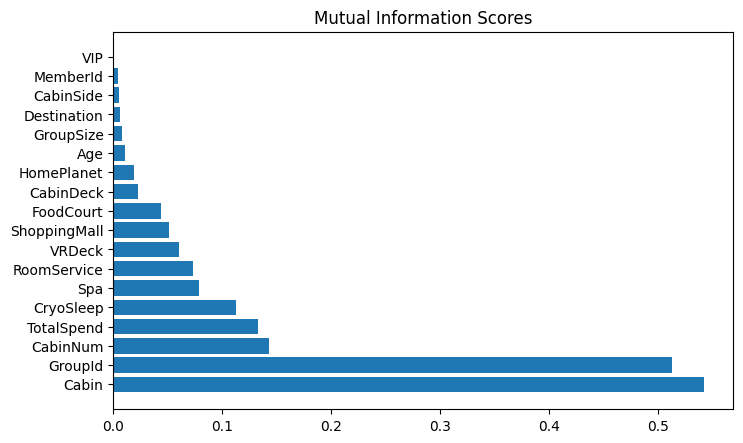

In [16]:
# plot mutual information scores

plt.figure(dpi=100, figsize=(8, 5))
width = np.arange(len(mi_scores))
ticks = list(mi_scores.index)
plt.barh(width, mi_scores)
plt.yticks(width, ticks)
plt.title("Mutual Information Scores")

# Deal with Missing Values

In [17]:
# modified a function found here -> https://stackoverflow.com/questions/1518522/find-the-most-common-element-in-a-list

from collections import Counter

def Most_Common(lst):
    data = Counter(lst.dropna())
    if len(data) > 0:
        return data.most_common(1)[0][0]
    else:
        return None

In [18]:
train_data2 = train_data.copy()

train_data2.loc[train_data2['HomePlanet'].isnull(),
                'HomePlanet'] = train_data2['GroupId'].map(train_data2.groupby(['GroupId'])['HomePlanet'].agg(Most_Common))

train_data2.loc[train_data2['HomePlanet'].isnull(), 'HomePlanet'] = Most_Common(train_data2['HomePlanet'])

In [19]:
# function to impute missing categorical values; column dtype must be 'object'
#def impute_categorical_values(column):
#    if column.dtype == 'object':
        
  #  else:
 #       print("Invalid dtype passed to function; must be 'object' dtype")

# Models

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Identify predictors to be used
features = ['HomePlanet', 'CryoSleep', 'Destination', 'Age',
            'GroupId', 'MemberId', 'CabinDeck', 'CabinNum',
            'CabinSide', 'TotalSpend'] 

# Separate target from predictors (target has no missing values)
y = train_data.Transported
X = train_data[features]

# select categorical columns
categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]


# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# define the xgb model
xgb_model = XGBClassifier()

n_est = np.arange(10, 150, step = 20).tolist()
learn_rate = np.arange(0.05, 0.55, step = 0.05).tolist()
parameters = {'n_estimators': n_est,
             'learning_rate': learn_rate}

my_xgb_model = GridSearchCV(xgb_model, 
                            param_grid=parameters,
                            scoring='accuracy')


# Define the random forest model
rf_model = RandomForestClassifier()

max_depths = np.arange(1, 10).tolist()
n_est = np.arange(20, 200, step = 20).tolist()
parameters = {'n_estimators': n_est, 
              'max_depth': max_depths}

my_rf_model = GridSearchCV(rf_model, param_grid=parameters, 
                           scoring='accuracy')



# Bundle preprocessing and modeling code in a pipeline for xbg model
my_xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('model', my_xgb_model)
                                 ])

# Bundle preprocessing and modeling code in a pipeline for random forest model
my_rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('model', my_rf_model)
                                ])

In [21]:
# Preprocess training data, fit xgb model 
my_xgb_pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Age', 'TotalSpend']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Destination', 'GroupId',
                                                   'MemberId', 'CabinDeck',
                                                   'CabinNum',
                           

In [22]:
print("Best Parameters:\n", my_xgb_pipeline['model'].best_params_, "\n")
#print("CV Results:\n", my_xgb_pipeline['model'].cv_results_, "\n")
print("Best Score:\n", my_xgb_pipeline['model'].best_score_)

Best Parameters:
 {'learning_rate': 0.25, 'n_estimators': 10} 

Best Score:
 0.7472697362543848


In [23]:
# Preprocess training data, fit random forest model 
#my_rf_pipeline.fit(X, y)

In [24]:
#print("Best Parameters:\n", my_rf_pipeline['model'].best_params_, "\n")
#print("Best Score:\n", my_rf_pipeline['model'].best_score_)

# Make Predictions on Test Set

In [25]:
# make predictions on the test data for submission

test_data[['GroupId', 'MemberId']] = test_data['PassengerId'].str.split("_", expand=True)
test_data[['CabinDeck', 'CabinNum', 'CabinSide']] = test_data['Cabin'].str.split("/", expand=True)
test_data['TotalSpend'] = test_data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

X_test = test_data[features]
predictions = my_xgb_pipeline.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Transported': predictions.astype('bool')})
output.to_csv('submission.csv', index=False)

Try imputation by group; keep working on feature engineering (use default xgb to compare for speed)